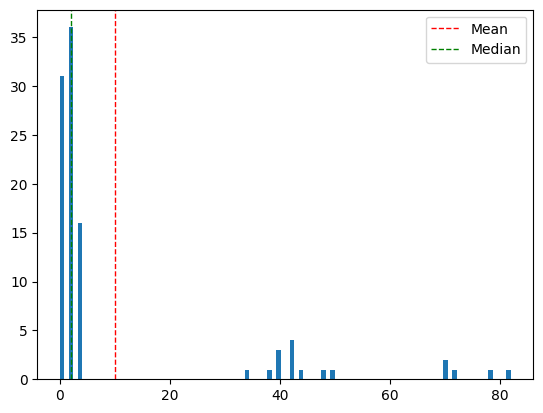

In [43]:
from brian2 import *
from matrices import import_light, import_dog_inh, import_v1
%matplotlib inline
import numpy as np
import pytime

nL1 = nL2 = 5**2
nL3 = nL1*4
n = np.sqrt(nL1).astype(int)

[X,Y] = np.meshgrid(np.linspace(1,n,n,dtype=int), np.linspace(1,n,n,dtype=int))

taum = 10*ms
taue = taui = 5*ms
duration = 500*ms

eqsPOISSON ='''
rates : Hz
x : 1 (constant)
y : 1 (constant)
'''

eqsCUBALIF ='''
dv/dt  = (ge-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
x : 1 (constant)
y : 1 (constant)
'''

eqsV1 ='''
dv/dt  = (ge-v)/taum : volt (unless refractory)
dge/dt = -ge/taue : volt
x : 1 (constant)
y : 1 (constant)
ori : 1 (constant)
'''

ind = 0

################################################## Layer 1 ################################################################

L1 = NeuronGroup(nL1,
                 eqsPOISSON,
                 threshold='rand()<rates*dt')

L1.x = X.flatten()
L1.y = Y.flatten()
pat = import_light()
L1.rates = pat[ind]*100*Hz

################################################## Layer 2 ################################################################

L2 = NeuronGroup(nL2,
                 eqsCUBALIF,
                 threshold = 'v>0.3*volt',
                 reset = 'v=0*volt',
                 refractory = 5*ms,
                 method = 'euler')

L2.x = X.flatten()
L2.y = Y.flatten()

e1 = Synapses(L1, L2, 'w : volt', on_pre='ge += w')
e1.connect(condition = 'i==j')
e1.w = 8*volt

i1 = Synapses(L1, L2, 'w : volt', on_pre='ge -= w')
i1.connect(condition = 'sqrt((x_pre - x_post)**2 + (y_pre-y_post)**2) < 2 and i!=j')
i1.w = 1*volt

################################################## Layer 3 ################################################################

L3 = NeuronGroup(nL3,
                 eqsV1,
                 threshold='v>0.3*volt',
                 reset='v = 0*volt',
                 refractory=5*ms,
                 method='euler')

L3.ori = np.repeat(np.array([0,1,2,3]), nL1)

X3 = np.tile(X.flatten(), (1,4))
X3.flatten()
L3.x = X3.flatten()

Y3 = np.tile(Y.flatten(), (1,4))
Y3.flatten()
L3.y = Y3.flatten()

e2 = Synapses(L2, L3, 'w : volt', on_pre='ge += w')
e2.connect(condition = 'ori_post==0 and (y_pre-y_post)**2<=1 and x_pre==x_post or ori_post==1 and (x_pre-x_post)**2<=1 and y_pre==y_post or ori_post==2 and(x_pre==x_post-1 and y_pre==y_post-1 or x_pre==x_post and y_pre==y_post or x_pre==x_post+1 and y_pre==y_post+1) or ori_post==3 and (x_pre==x_post+1 and y_pre==y_post-1 or x_pre==x_post and y_pre==y_post or x_pre==x_post-1 and y_pre==y_post+1)')
e2.w = volt/3

sp1 = SpikeMonitor(L1)
st = StateMonitor(L2,'v',record=True)
sp2 = SpikeMonitor(L2)
sp3 = SpikeMonitor(L3)
run(duration)
mfr1 = sp1.count/duration
mfr2 = sp2.count/duration
mfr3 = sp3.count/duration

#tmp = mfr3[0:25]
#tmp.reshape(5,5)
#tmp = mfr3[25:50]
#tmp.reshape(5,5)
#tmp = mfr3[50:75]
#tmp.reshape(5,5)
#tmp = mfr3[75:100]
#tmp.reshape(5,5)

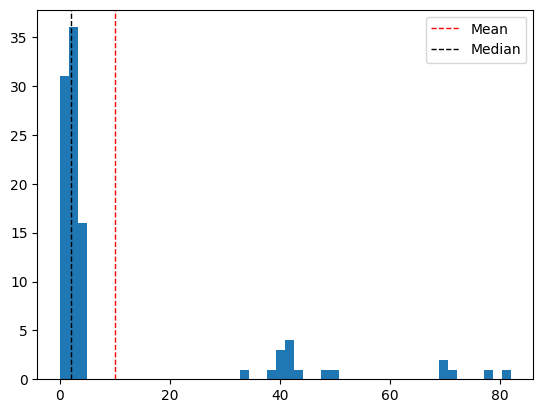

In [50]:
tmp = asarray(mfr3)
plt.hist(tmp, bins=50)
plt.axvline(tmp.mean(), color='r', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(median(tmp), color='k', linestyle='dashed', linewidth=1, label='Median')
plt.legend()
plt.show()